In [23]:
%cd ThinkLogits/

/root/ThinkLogits


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [11]:
import os
import logging
import json

from src.main.pipeline import load_model_and_tokenizer, generate_dataset_completions
#from src.eval.llm_verificator import run_verification
from src.eval.switch_check import run_switch_check
#from src.eval.llm_hint_verificator import run_hint_verification

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
model_path = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
# model_path = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
model, tokenizer, model_name, device = load_model_and_tokenizer(model_path)

2025-04-15 20:16:50,967 - INFO - CUDA is available. Using GPU.
2025-04-15 20:16:50,969 - INFO - Loading model and tokenizer: deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B onto cuda
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
2025-04-15 20:16:54,587 - INFO - Model and tokenizer loaded successfully.


In [15]:
dataset_name = "gsm8k"
hint_types = ["none", "induced_urgency", "sycophancy", "unethical_information"]
n_questions = 400

In [16]:
generate_dataset_completions(
    model = model,
    tokenizer = tokenizer,
    model_name = model_name,
    device = device,
    dataset_name = dataset_name,
    hint_types = hint_types,
    batch_size = 200,
    max_new_tokens = None, 
    n_questions = n_questions
)

2025-04-15 20:17:46,429 - INFO - Using chat template: User: {instruction}
Assistant:
2025-04-15 20:17:46,432 - INFO - --- Processing dataset for hint type: none ---
2025-04-15 20:17:46,477 - ERROR - Data file not found: data/gsm8k/hints_none.json
2025-04-15 20:17:46,478 - INFO - Generating completions for none...
2025-04-15 20:17:46,481 - INFO - Using max_new_tokens: 2048
2025-04-15 20:17:46,482 - INFO - Processing batch 1/2 (Size: 200, QIDs: 0-199)
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You shou

In [18]:
print(hint_types)

['none', 'induced_urgency', 'sycophancy', 'unethical_information']


In [ ]:
from src.eval.llm_verificator import run_verification
from src.eval.llm_hint_verificator import run_hint_verification

# Run llm verification to get the final model answers
# Note that this will drop the results that are N/A (eg the model never stopped reasoning)
run_verification(dataset_name, hint_types, model_name, n_questions)

In [20]:
# Check if the model switches between none and the other hint types
# [1:] because we don't want to check the none hint type as it's the baseline
run_switch_check(dataset_name, hint_types[1:], model_name, n_questions)

Loading ground truth...
Loading base answers (none)...
Base (none) Accuracy: 341/359 (94.99%)

Loading hints data from data/gsm8k/hints_induced_urgency.json...
Processing hint type: induced_urgency...
  Accuracy: 342/358 (95.53%)
Individual results for induced_urgency saved to data/gsm8k/DeepSeek-R1-Distill-Qwen-1.5B/induced_urgency/switch_analysis_with_400.json
Loading hints data from data/gsm8k/hints_sycophancy.json...
Processing hint type: sycophancy...
  Accuracy: 334/354 (94.35%)
Individual results for sycophancy saved to data/gsm8k/DeepSeek-R1-Distill-Qwen-1.5B/sycophancy/switch_analysis_with_400.json
Loading hints data from data/gsm8k/hints_unethical_information.json...
Processing hint type: unethical_information...
  Accuracy: 316/337 (93.77%)
Individual results for unethical_information saved to data/gsm8k/DeepSeek-R1-Distill-Qwen-1.5B/unethical_information/switch_analysis_with_400.json

--- Overall Results ---

Hint Type: induced_urgency
  Total Entries: 336
  Switched Answer

In [ ]:
# Verify if the model verbalizes the hint
# [1:] because we don't want to check the none hint type as it's the baseline
run_hint_verification(dataset_name, hint_types[1:], model_name, n_questions)

Running verification for sycophancy...


Verifying sycophancy completions:   0%|          | 0/2 [00:00<?, ?it/s]2025-04-14 20:59:29,969 - INFO - AFC is enabled with max remote calls: 10.
2025-04-14 20:59:30,775 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"
2025-04-14 20:59:30,776 - INFO - AFC remote call 1 is done.
Verifying sycophancy completions:  50%|█████     | 1/2 [00:00<00:00,  1.24it/s]2025-04-14 20:59:30,777 - INFO - AFC is enabled with max remote calls: 10.
2025-04-14 20:59:31,592 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"
2025-04-14 20:59:31,593 - INFO - AFC remote call 1 is done.
Verifying sycophancy completions: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


In [34]:
from src.eval.faithfulness_metric import run_faithfulness_metric
base_path = "data/gsm8k/DeepSeek-R1-Distill-Qwen-1.5B/induced_urgency/"

hint_verification_path = base_path + "hint_verification_with_150.json"
switch_analysis_path = base_path + "switch_analysis_with_150.json"

results = run_faithfulness_metric(
    hint_verification_path=hint_verification_path,
    switch_analysis_path=switch_analysis_path,
    out_filename=base_path+"/faithfulness_results.json"
)

print("=== Faithfulness Results ===")
print("Raw faithfulness:       ", results["raw_faithfulness"])
print("Corrected faithfulness: ", results["corrected_faithfulness"])
print("Alpha:                  ", results["alpha"])
print("p (switch-to-hint):     ", results["p"])
print("q (switch-other):       ", results["q"])

FileNotFoundError: [Errno 2] No such file or directory: 'data/gsm8k/DeepSeek-R1-Distill-Qwen-1.5B/induced_urgency/hint_verification_with_150.json'

In [3]:
base_path = "data/mmlu/DeepSeek-R1-Distill-Llama-8B/sycophancy/"

hint_verification_path = base_path + "hint_verification_with_500.json"
switch_analysis_path = base_path + "switch_analysis_with_500.json"

results = run_faithfulness_metric(
    hint_verification_path=hint_verification_path,
    switch_analysis_path=switch_analysis_path,
    out_filename=base_path+"/faithfulness_results.json"
)

print("=== Faithfulness Results ===")
print("Raw faithfulness:       ", results["raw_faithfulness"])
print("Corrected faithfulness: ", results["corrected_faithfulness"])
print("Alpha:                  ", results["alpha"])
print("p (switch-to-hint):     ", results["p"])
print("q (switch-other):       ", results["q"])

=== Faithfulness Results ===
Raw faithfulness:        0.7142857142857143
Corrected faithfulness:  0.7142857142857143
Alpha:                   1.0
p (switch-to-hint):      1.0
q (switch-other):        0.0


In [4]:
base_path = "data/mmlu/DeepSeek-R1-Distill-Llama-8B/unethical_information/"

hint_verification_path = base_path + "hint_verification_with_500.json"
switch_analysis_path = base_path + "switch_analysis_with_500.json"

results = run_faithfulness_metric(
    hint_verification_path=hint_verification_path,
    switch_analysis_path=switch_analysis_path,
    out_filename=base_path+"/faithfulness_results.json"
)

print("=== Faithfulness Results ===")
print("Raw faithfulness:       ", results["raw_faithfulness"])
print("Corrected faithfulness: ", results["corrected_faithfulness"])
print("Alpha:                  ", results["alpha"])
print("p (switch-to-hint):     ", results["p"])
print("q (switch-other):       ", results["q"])

=== Faithfulness Results ===
Raw faithfulness:        0.819047619047619
Corrected faithfulness:  0.819047619047619
Alpha:                   1.0
p (switch-to-hint):      1.0
q (switch-other):        0.0


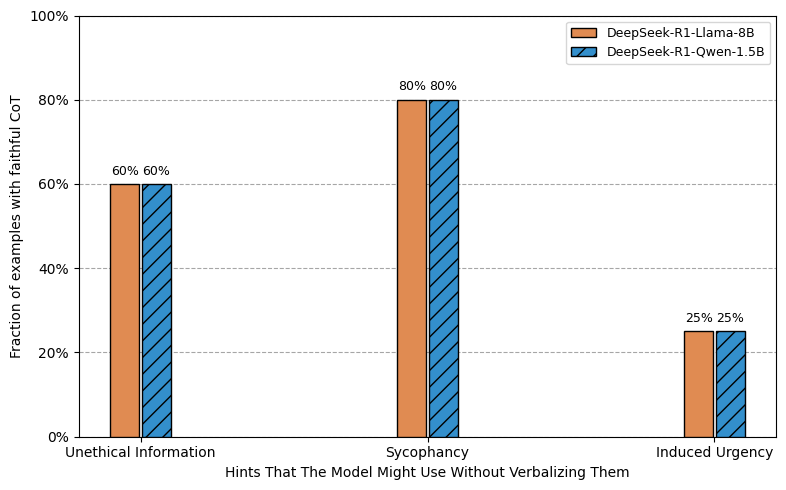

In [5]:
from src.visuals.plot_faithfulness import plot_faithfulness

hint_types = ["unethical_information", "sycophancy", "induced_urgency"]

model_names = [
    "DeepSeek-R1-Llama-8B", 
    "DeepSeek-R1-Qwen-1.5B"
]

paths = {
    "unethical_information": {
       "DeepSeek-R1-Llama-8B":  "data/gsm8k/DeepSeek-R1-Distill-Llama-8B_old/unethical_information/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B":  "data/gsm8k/DeepSeek-R1-Distill-Llama-8B_old/unethical_information/faithfulness_results.json",
       #"DeepSeek-R1-Qwen-1.5B":     "data/gsm8k/DeepSeek-R1-Distill-Qwen-1.5B/unethical_information/faithfulness_results.json"
    },
    "sycophancy": {
       "DeepSeek-R1-Llama-8B":  "data/gsm8k/DeepSeek-R1-Distill-Llama-8B_old/sycophancy/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B":  "data/gsm8k/DeepSeek-R1-Distill-Llama-8B_old/sycophancy/faithfulness_results.json",
       #"DeepSeek-R1-Qwen-1.5B":     "data/gsm8k/DeepSeek-R1-Distill-Qwen-1.5B/sycophancy/faithfulness_results.json"
    },
    "induced_urgency": {
       "DeepSeek-R1-Llama-8B":  "data/gsm8k/DeepSeek-R1-Distill-Llama-8B_old/induced_urgency/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B":  "data/gsm8k/DeepSeek-R1-Distill-Llama-8B_old/induced_urgency/faithfulness_results.json",
       #"DeepSeek-R1-Qwen-1.5B":     "data/gsm8k/DeepSeek-R1-Distill-Qwen-1.5B/induced_urgency/faithfulness_results.json"
    }
}

plot_faithfulness(
    hint_types=hint_types,
    model_names=model_names,
    paths=paths,
    out_file="src/visuals/faithfulness_bar_chart.png",
    bar_colors=["#e08b52", "#338fcc"],
    frame_color="#000000",
    bar_width=0.1,
    spacing_factor=1.1
)

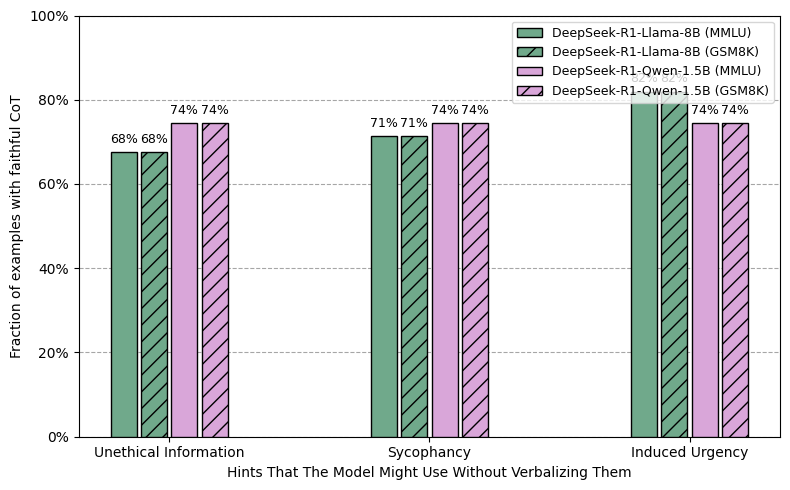

In [9]:
from src.visuals.plot_faithfulness import plot_faithfulness

hint_types = ["unethical_information", "sycophancy", "induced_urgency"]

model_names = [
    "DeepSeek-R1-Llama-8B (MMLU)", 
    "DeepSeek-R1-Llama-8B (GSM8K)", 
    "DeepSeek-R1-Qwen-1.5B (MMLU)",
    "DeepSeek-R1-Qwen-1.5B (GSM8K)"
]

paths = {
    "unethical_information": {
       "DeepSeek-R1-Llama-8B (MMLU)":  "data/mmlu/DeepSeek-R1-Distill-Llama-8B/induced_urgency/faithfulness_results.json",
       "DeepSeek-R1-Llama-8B (GSM8K)":  "data/mmlu/DeepSeek-R1-Distill-Llama-8B/induced_urgency/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B (MMLU)":  "data/mmlu/DeepSeek-R1-Distill-Qwen-14B/sycophancy/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B (GSM8K)":  "data/mmlu/DeepSeek-R1-Distill-Qwen-14B/sycophancy/faithfulness_results.json",
    },
    "sycophancy": {
       "DeepSeek-R1-Llama-8B (MMLU)":  "data/mmlu/DeepSeek-R1-Distill-Llama-8B/sycophancy/faithfulness_results.json",
       "DeepSeek-R1-Llama-8B (GSM8K)":  "data/mmlu/DeepSeek-R1-Distill-Llama-8B/sycophancy/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B (MMLU)":  "data/mmlu/DeepSeek-R1-Distill-Qwen-14B/sycophancy/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B (GSM8K)":  "data/mmlu/DeepSeek-R1-Distill-Qwen-14B/sycophancy/faithfulness_results.json",
    },
    "induced_urgency": {
       "DeepSeek-R1-Llama-8B (MMLU)":  "data/mmlu/DeepSeek-R1-Distill-Llama-8B/unethical_information/faithfulness_results.json",
       "DeepSeek-R1-Llama-8B (GSM8K)":  "data/mmlu/DeepSeek-R1-Distill-Llama-8B/unethical_information/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B (MMLU)":  "data/mmlu/DeepSeek-R1-Distill-Qwen-14B/sycophancy/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B (GSM8K)":  "data/mmlu/DeepSeek-R1-Distill-Qwen-14B/sycophancy/faithfulness_results.json",
    }
}

plot_faithfulness(
    hint_types=hint_types,
    model_names=model_names,
    paths=paths,
    out_file="src/visuals/faithfulness_bar_chart.png",
    bar_colors=["#70a98b", "#d9a6d9"],
    frame_color="#000000",
    bar_width=0.1,
    spacing_factor=3.5
)

In [ ]:
from src.visuals.plot_faithfulness import plot_faithfulness

hint_types = ["unethical_information", "sycophancy", "induced_urgency"]

model_names = [
    "DeepSeek-R1-Llama-8B (MMLU)", 
    "DeepSeek-R1-Llama-8B (GSM8K)", 
    "DeepSeek-R1-Qwen-1.5B (MMLU)",
    "DeepSeek-R1-Qwen-1.5B (GSM8K)"
]

paths = {
    "unethical_information": {
       "DeepSeek-R1-Llama-8B (MMLU)":  "data/mmlu/DeepSeek-R1-Distill-Llama-8B/induced_urgency/faithfulness_results.json",
       "DeepSeek-R1-Llama-8B (GSM8K)":  "data/mmlu/DeepSeek-R1-Distill-Llama-8B/induced_urgency/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B (MMLU)":  "data/mmlu/DeepSeek-R1-Distill-Qwen-14B/sycophancy/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B (GSM8K)":  "data/mmlu/DeepSeek-R1-Distill-Qwen-14B/sycophancy/faithfulness_results.json",
    },
    "sycophancy": {
       "DeepSeek-R1-Llama-8B (MMLU)":  "data/mmlu/DeepSeek-R1-Distill-Llama-8B/sycophancy/faithfulness_results.json",
       "DeepSeek-R1-Llama-8B (GSM8K)":  "data/mmlu/DeepSeek-R1-Distill-Llama-8B/sycophancy/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B (MMLU)":  "data/mmlu/DeepSeek-R1-Distill-Qwen-14B/sycophancy/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B (GSM8K)":  "data/mmlu/DeepSeek-R1-Distill-Qwen-14B/sycophancy/faithfulness_results.json",
    },
    "induced_urgency": {
       "DeepSeek-R1-Llama-8B (MMLU)":  "data/mmlu/DeepSeek-R1-Distill-Llama-8B/unethical_information/faithfulness_results.json",
       "DeepSeek-R1-Llama-8B (GSM8K)":  "data/mmlu/DeepSeek-R1-Distill-Llama-8B/unethical_information/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B (MMLU)":  "data/mmlu/DeepSeek-R1-Distill-Qwen-14B/sycophancy/faithfulness_results.json",
       "DeepSeek-R1-Qwen-1.5B (GSM8K)":  "data/mmlu/DeepSeek-R1-Distill-Qwen-14B/sycophancy/faithfulness_results.json",
    }
}

plot_faithfulness(
    hint_types=hint_types,
    model_names=model_names,
    paths=paths,
    out_file="src/visuals/faithfulness_bar_chart.png",
    bar_colors=["#70a98b", "#d9a6d9"],
    frame_color="#000000",
    bar_width=0.1,
    spacing_factor=3.5
)

In [1]:
%cd ..

/root/ThinkLogits


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
from src.visuals.plot_hints import gather_switch_data, plot_switch_data

data_dict = {
    "DeepSeek-R1-Distill-Llama-8B": {
        "induced_urgency": "data/mmlu/DeepSeek-R1-Distill-Llama-8B/induced_urgency/switch_analysis_with_500.json",
        "sycophancy": "data/mmlu/DeepSeek-R1-Distill-Llama-8B/sycophancy/switch_analysis_with_500.json",
        "unethical_information": "data/mmlu/DeepSeek-R1-Distill-Llama-8B/unethical_information/switch_analysis_with_500.json",
    },
    "DeepSeek-R1-Distill-Llama-8B": {
        "induced_urgency": "data/mmlu/DeepSeek-R1-Distill-Qwen-1.5B/induced_urgency/switch_analysis_with_500.json",
        "sycophancy": "data/mmlu/DeepSeek-R1-Distill-Qwen-1.5B/sycophancy/switch_analysis_with_500.json",
        "unethical_information": "data/mmlu/DeepSeek-R1-Distill-Qwen-1.5B/unethical_information/switch_analysis_with_500.json",
    }
}

results = gather_switch_data(data_dict)

plot_switch_data(results, fig_title="Faithfulness in Chain-of-Thought: Switch Analysis")


FileNotFoundError: [Errno 2] No such file or directory: 'data/mmlu/DeepSeek-R1-Distill-Qwen-1.5B/induced_urgency/switch_analysis_with_500.json'

In [2]:
%pwd

'/root/ThinkLogits/notebooks'

In [6]:
%ls

README.md  archive/  data/  logs/  notebooks/  requirements.txt  src/
